### レシート解析（google-cloud-visionが使えるGCPと接続したgoogle colabolatry上で実行可能）
- 参考文献：https://qiita.com/shoku-pan/items/bf5645894803769edc72

#### google-cloud-visionをインストール

In [ ]:
pip install google-cloud-vision

     |████████████████████████████████| 370 kB 6.7 MB/s 
     |████████████████████████████████| 109 kB 53.6 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 4.1 MB 41.6 MB/s 
     |████████████████████████████████| 1.1 MB 54.7 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 1.26.3
    Uninstalling google-api-core-1.26.3:
      Successfully uninstalled google-api-core-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 

##### ライブラリをインポート

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import platform
print("python " + platform.python_version())
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import os
import io
from google.cloud import vision
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
python 3.7.12


##### GCPと接続

In [ ]:
json_path = ""

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_path # json_pathは、サービスアカウントキーのパス

##### Google Drive上の画像データ読み込み（事前にドライブ上に画像を保存する必要あり）

In [ ]:
input_files = []
for i in range(10):
  input_files.append("/content/drive/MyDrive/Colab_Notebooks/img/img%d.jpg"%i)

##### Google Cloud Visionを用いて文字検出

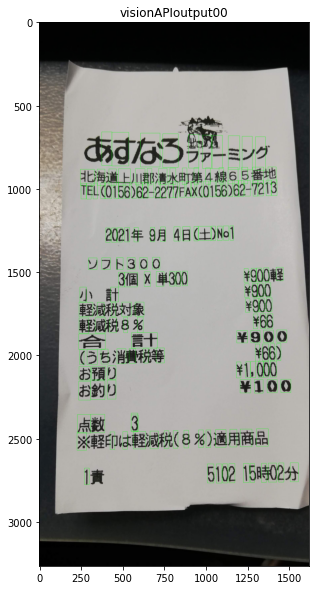

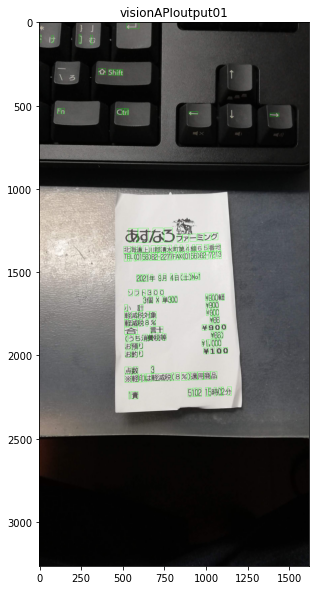

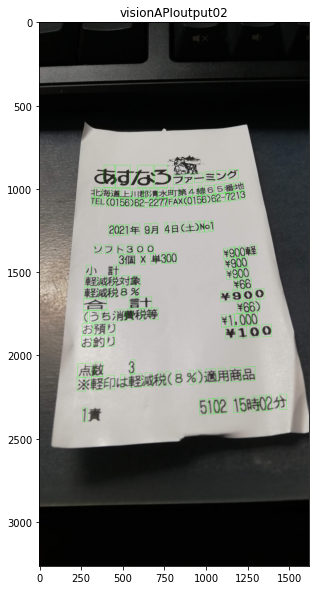

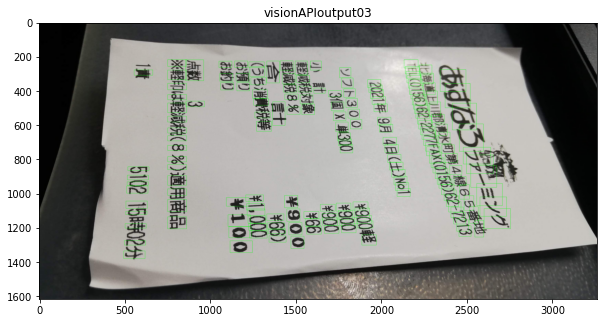

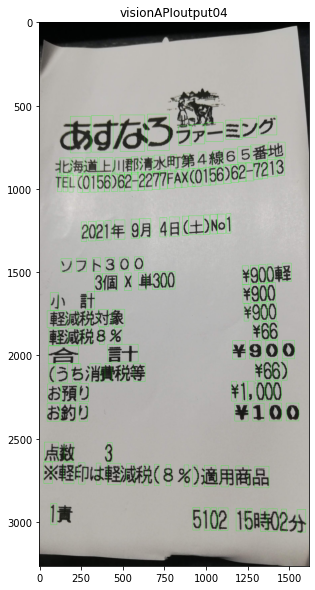

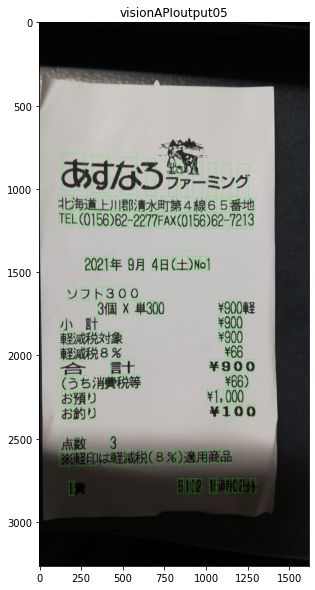

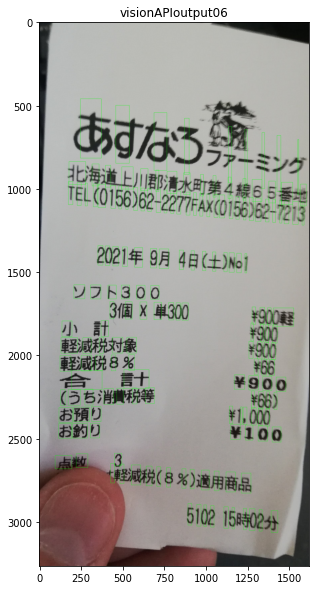

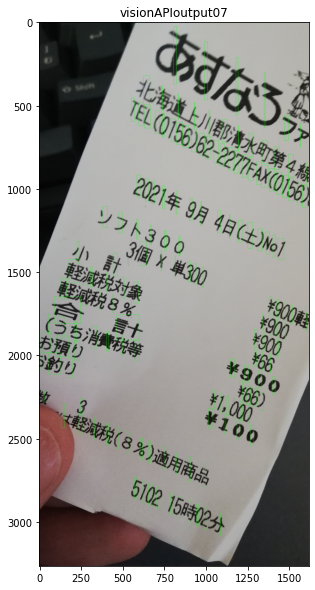

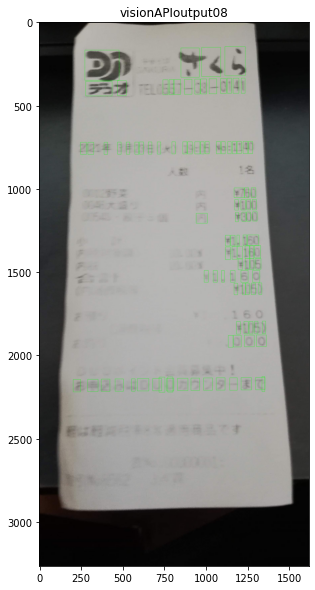

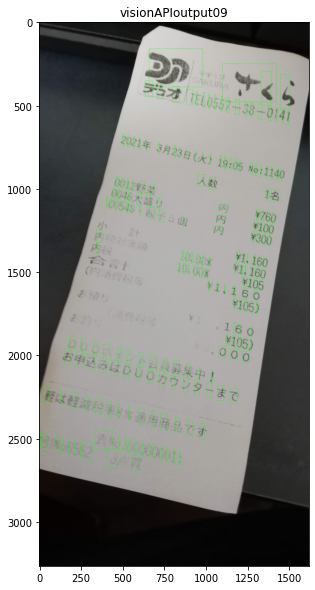

In [ ]:
results = {}
for i_index, i_input_file in enumerate(input_files):
  results[i_input_file] = {}
  img = cv2.imread(i_input_file) # input_fileは画像のパス
  client = vision.ImageAnnotatorClient()
  with io.open(i_input_file, 'rb') as image_file:
      content = image_file.read()
  image = vision.Image(content=content)
  response = client.document_text_detection(image=image)
  results[i_input_file]["response"] = response
  document = response.full_text_annotation
  img_symbol = img.copy()
  for page in document.pages:
    for block in page.blocks:
      for paragraph in block.paragraphs:
        for word in paragraph.words:
          for symbol in word.symbols:
            bounding_box = symbol.bounding_box
            xmin = bounding_box.vertices[0].x
            ymin = bounding_box.vertices[0].y
            xmax = bounding_box.vertices[2].x
            ymax = bounding_box.vertices[2].y
            cv2.rectangle(img_symbol, (xmin, ymin), (xmax, ymax), (0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
  results[i_input_file]["img"] = img_symbol[:,:,::-1]
  plt.figure(figsize=[10,10])
  plt.imshow(img_symbol[:,:,::-1]);plt.title("visionAPIoutput%02d"%i_index)

##### 任意の画像とその画像から検出された文字情報を出力

In [ ]:
i_data = 7
plt.figure(figsize=[10,10])
plt.imshow(results[input_files[i_data]]["img"])
print(results[input_files[i_data]]["response"].text_annotations[0].description)

##### 合計金額を検出する関数

In [ ]:
def detect_total_sum(text_annotations):
  i_return = None
  for i_text_annotation, text_anotation in enumerate(text_annotations):
    if text_anotation.description in ["合計", "総計"]:
      if i_return != None:
        raise Exception("Error: detected multiple total sum")
      i_return = i_text_annotation
  if i_return == None:
    raise Exception("Error: could not detect the specified string")
  return i_return

def return_det_vector(vertice):
  edge_len_list = []
  for i in range(4):
    if not i == 3:
      edge_len_list.append((vertice[i].x - vertice[i+1].x)**2 + (vertice[i].y - vertice[i+1].y)**2)
    else:
      edge_len_list.append((vertice[3].x - vertice[0].x)**2 + (vertice[3].y - vertice[0].y)**2)
  max_edge_index = edge_len_list.index(max(edge_len_list))
  if max_edge_index in [0,2]:
    edge_long_01_23_flg = True
  else:
    edge_long_01_23_flg = False
  
  if edge_long_01_23_flg:
    x_slope = (vertice[0].x-vertice[1].x+vertice[3].x-vertice[2].x)/2
    y_slope = (vertice[0].y-vertice[1].y+vertice[3].y-vertice[2].y)/2
    det_vector = np.array([-y_slope, x_slope])
  else:
    x_slope = (vertice[0].x-vertice[3].x+vertice[1].x-vertice[2].x)/2
    y_slope = (vertice[0].y-vertice[3].y+vertice[1].y-vertice[2].y)/2
    det_vector = np.array([-y_slope, x_slope])
  return det_vector/np.linalg.norm(det_vector, ord=2)

def return_center(vertices):
  x_sum = 0
  y_sum = 0
  for i, vertice in enumerate(vertices):
    x_sum += vertice.x
    y_sum += vertice.y
  return np.array([x_sum/(i+1), y_sum/(i+1)])

def print_total_sum(response):
  text_annotations = response.text_annotations[1:]
  total_sum_index = detect_total_sum(text_annotations)

  total_sum_vertices = text_annotations[total_sum_index].bounding_poly.vertices
  det_vector = return_det_vector(total_sum_vertices)
  total_sum_center = return_center(total_sum_vertices)

  diff_list = {}
  for i_text_annotation_index, i_text_anotation in enumerate(text_annotations):
    if not i_text_annotation_index == total_sum_index:
      i_vertices_center = return_center(i_text_anotation.bounding_poly.vertices)
      i_center_diff = total_sum_center - i_vertices_center
      i_normed_center_diff = i_center_diff/np.linalg.norm(i_center_diff, ord=2)
      diff_list[i_text_annotation_index] = np.dot(det_vector, i_normed_center_diff)

  sorted_index_diff_list = sorted(diff_list.items(), key=lambda x:abs(x[1]))
  total_sum = None
  for sorted_index_diff in sorted_index_diff_list:
    i_index = sorted_index_diff[0]
    i_description = text_annotations[i_index].description
    print("- i_description = %s"%i_description)
    try:
      total_sum = int(i_description)
      break
    except:
      pass
  if total_sum == None:
    raise Exception("Error: could not read total sum")

  print("> total sum = %d"%total_sum)

##### 合計金額検出例

In [ ]:
i_data = 0
response = results[input_files[i_data]]["response"]
print_total_sum(response)

- i_description = 900
> total sum = 900
